In [5]:
import pandas as pd 
import xarray as xr 
import pygmt
import numpy as np

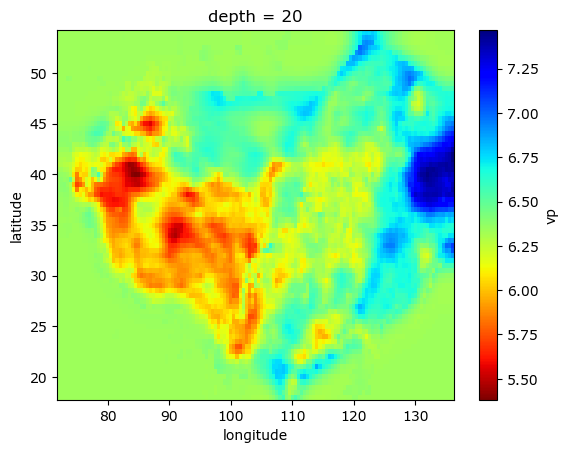

In [4]:
# read model and convert to xarray
# the model:https://github.com/ShouchengHan/USTClitho2.0/blob/main/USTClitho2.0.wrst.sea_level.txt
velocity = pd.read_csv('USTClitho2.0.wrst.sea_level.txt',sep='\s+',names=['longitude','latitude','depth','vp','vs'])
velocity = velocity.set_index(['latitude','longitude','depth'])
USTClitho2 = xr.Dataset.from_dataframe(velocity)
USTClitho2.vp.sel(depth=20).plot(cmap='jet_r')

In [6]:
# cut the model to region
region = [97,107,21,33,0,80]
lon1,lon2,lat1,lat2,dep1,dep2 = region
model = USTClitho2.where((USTClitho2.longitude >= lon1) & (USTClitho2.longitude <= lon2) & (USTClitho2.latitude >= lat1) & (USTClitho2.latitude <= lat2),drop=True)

# interpretation the model to 0.02*0.02*1
lons = np.arange(lon1,lon2+0.01,0.02)
lats = np.arange(lat1,lat2+0.01,0.02)
deps = np.arange(dep1,dep2+0.01,1)
model = model.interp(longitude=lons,latitude=lats,depth=deps)
model

<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 501, depth: 81)
Coordinates:
  * longitude  (longitude) float64 97.0 97.02 97.04 97.06 ... 107.0 107.0 107.0
  * latitude   (latitude) float64 21.0 21.02 21.04 21.06 ... 32.96 32.98 33.0
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 76.0 77.0 78.0 79.0 80.0
Data variables:
    vp         (latitude, longitude, depth) float64 4.5 4.659 ... 8.319 8.341
    vs         (latitude, longitude, depth) float64 2.66 2.756 ... 4.634 4.641

In [7]:
# get the topography
topo = pygmt.datasets.load_earth_relief(resolution='15s',region=region)
clon,clat = 102,28
index = (topo.lon >= clon ) & (topo.lon <= lon2) & (topo.lat <= clat) & (topo.lat >= lat1)
ele = topo.where(~index)
ele.data = -1*ele.data/1000

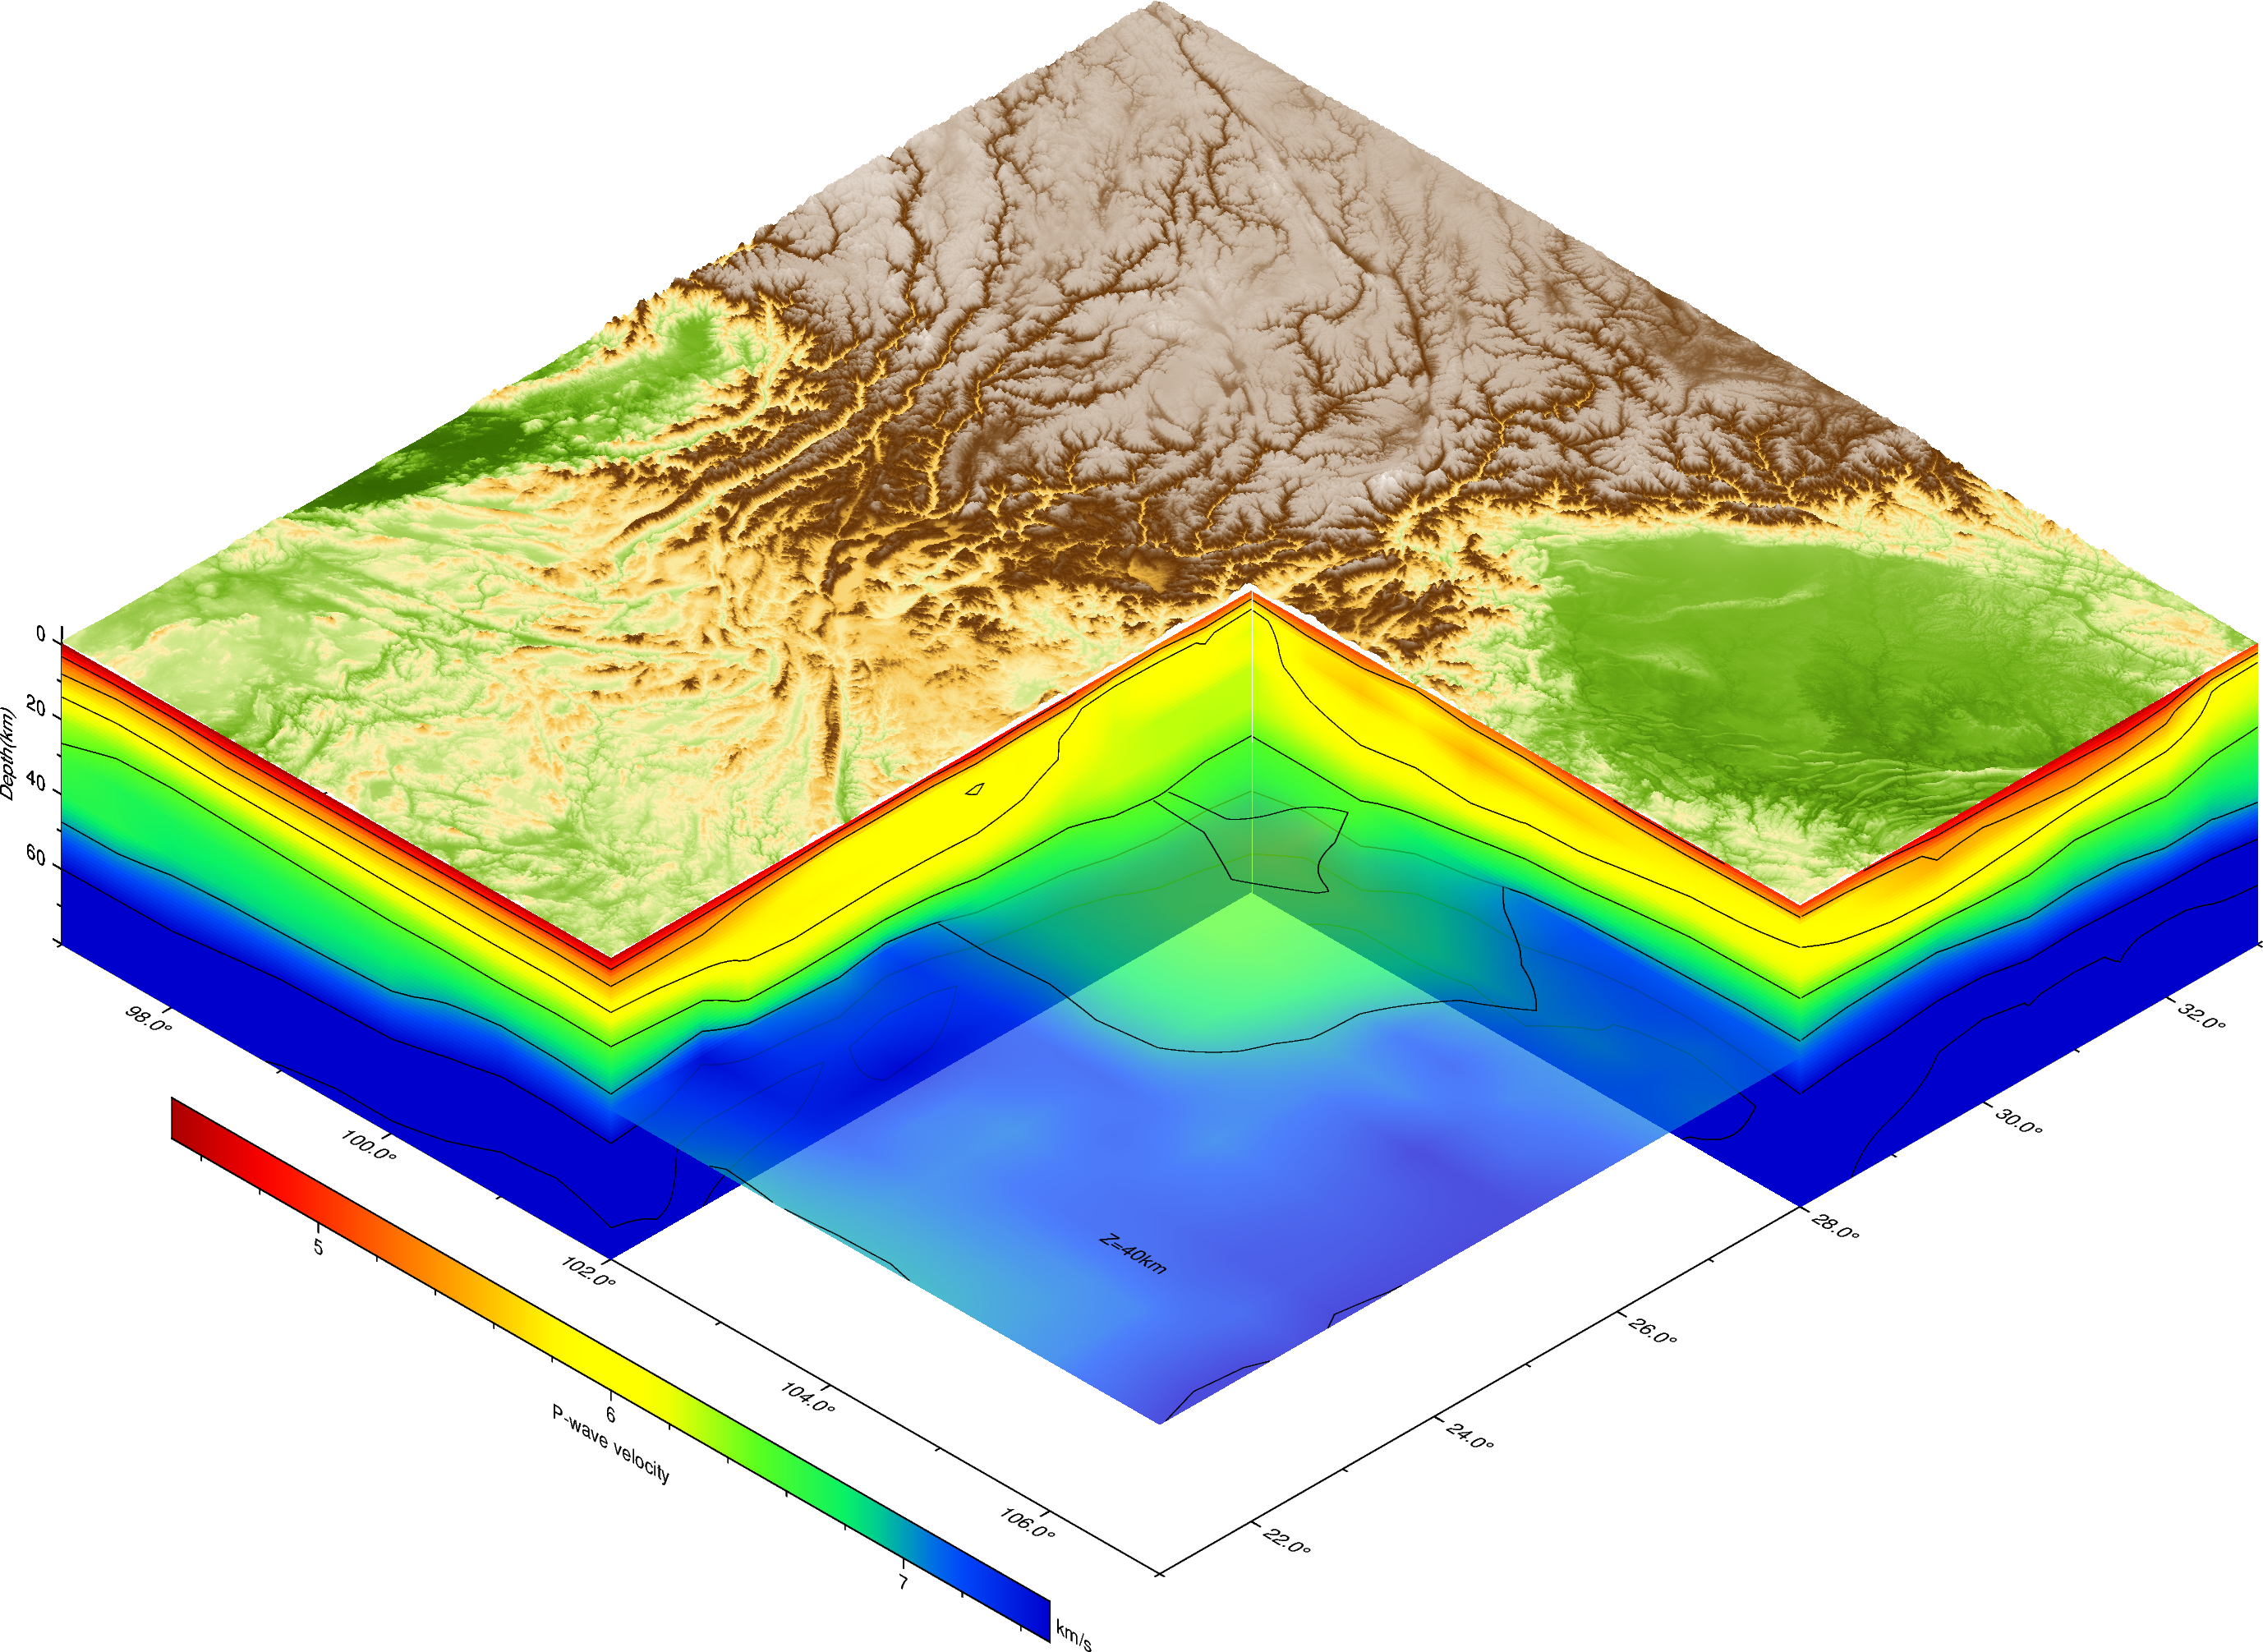

In [39]:
# plot the 3d mapview of model
azimuth = 135
elevation = 35
pz='{}/{}'.format(azimuth,elevation)
frame = ['xa2f1+llongitude','ya2f1+llatitude','zaf+l"Depth(km)"','wSEnZ']
region = [97,107,21,33,-5,80]
lon1,lon2,lat1,lat2,dep1,dep2 = region

map_x,map_y,map_z=16,16,4
fig = pygmt.Figure()
fig.basemap(region=region,projection='X{}cd/{}cd'.format(map_x,map_y),zsize='-{}c'.format(map_z),perspective='z'+pz,frame=frame)
pygmt.grd2cpt(grid=ele,cmap='dem1',reverse=True,continuous=True)
fig.grdview(grid=ele,cmap=True,surftype='i',perspective='z'+pz)

pygmt.makecpt(cmap='seis',series=[4.5,7.5,0.1],continuous=True,background=True)

grid = model.where((model.longitude>=lon1)&(model.longitude<=102),drop=True)
xz = grid.vp.sel(latitude=21,method='nearest')
rxz = [lon1,lon2,dep1,dep2,lat1,lat2]
fig.grdimage(grid=xz.transpose(),cmap=True,region=rxz,projection=['X{}c/-{}c'.format(map_x,map_z),'Z{}c'.format(map_y)],perspective='y'+pz+'/21.0')
fig.grdcontour(grid=xz.transpose(),perspective=True,interval=0.5)
fig.colorbar(cmap=True,frame=['xaf+lP-wave velocity','y+lkm/s'],perspective=True)

grid = model.where((model.longitude>=102)&(model.longitude<=lon2),drop=True)
xz = grid.vp.sel(latitude=28,method='nearest')
fig.grdimage(grid=xz.transpose(),cmap=True,perspective='y'+pz+'/28.0')
fig.grdcontour(grid=xz.transpose(),perspective=True,interval=0.5)

grid = model.where((model.latitude>=lat1)&(model.latitude<=28),drop=True)
yz = grid.vp.sel(longitude=102,method='nearest')
ryz = [lat1,lat2,dep1,dep2,lon1,lon2]
fig.grdimage(grid=yz.transpose(),cmap=True,region=ryz,projection=['X{}c/-{}c'.format(map_y,map_z),'Z{}c'.format(map_x)],perspective='x'+pz+'/102')
fig.grdcontour(grid=yz.transpose(),perspective=True,interval=0.5)

grid = model.where((model.latitude>=28)&(model.latitude<=lat2),drop=True)
yz = grid.vp.sel(longitude=107,method='nearest')
fig.grdimage(grid=yz.transpose(),cmap=True,perspective='x'+pz+'/107')
fig.grdcontour(grid=yz.transpose(),perspective=True,interval=0.5)

grid = model.where((model.longitude >= 102) & (model.longitude <= lon2) & (model.latitude >= lat1) & (model.latitude <= 28),drop=True)
xy = grid.vp.sel(depth=40,method='nearest')
rxy = [lon1,lon2,lat1,lat2,dep1,dep2]
fig.grdimage(grid=xy,cmap=True,region=rxy,projection=['X{}c/{}c'.format(map_x,map_y),'Z-{}c'.format(map_z)],perspective='z'+pz+'/40',transparency=30)
fig.grdcontour(grid=xy,perspective=True,interval=0.5)
fig.text(position='cBR',text='Z=40km',perspective=True)

fig.show()